# Trying to load a dataset

In [1]:
import torchvision
import torch
from torchinfo import summary
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights


num_classes = 2 # 0=ball, 1=player

# load a model, where the backbone is already trained, and the output layers aren't (at least, this should be the case...)
# also set the number of output classes to the number we need
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes, weights_backbone=True)


# freeze all layers, except the output heads
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True 


summary(model=model,   # can also look at "model=trained_model"
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


C:\Users\jl\Miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jl\Miniconda3\envs\torch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\jl\Miniconda3\envs\torch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
SSD (SSD)                                                              [1, 3, 224, 224]     [137, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                                 [1, 3, 224, 224]     [1, 3, 320, 320]     --                   --
├─SSDLiteFeatureExtractorMobileNet (backbone)                          [1, 3, 320, 320]     [1, 128, 1, 1]       --                   False
│    └─Sequential (features)                                           --                   --                   --                   False
│    │    └─Sequential (0)                                             [1, 3, 320, 320]     [1, 672, 20, 20]     (869,096)            False
│    │    └─Sequential (1)                                             [1, 672, 20, 20]     [1, 960, 10, 10]     (2,102,856)          False
│    └─ModuleList

In [2]:
model

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

# Load the Datasets

In [3]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn   # these are custom for our dataset


# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 8 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [4]:
test_dataset[0][1]

{'boxes': tensor([[ 316.,  218.,  332.,  252.],
         [ 383.,  231.,  398.,  264.],
         [ 458.,  197.,  477.,  233.],
         [ 430.,  273.,  444.,  305.],
         [ 437.,  294.,  453.,  331.],
         [ 475.,  324.,  492.,  363.],
         [ 400.,  386.,  415.,  428.],
         [ 515.,  407.,  530.,  452.],
         [ 526.,  244.,  539.,  277.],
         [ 552.,  252.,  567.,  287.],
         [ 627.,  246.,  641.,  275.],
         [ 648.,  199.,  664.,  234.],
         [ 662.,  202.,  674.,  233.],
         [ 759.,  342.,  772.,  380.],
         [ 774.,  267.,  789.,  304.],
         [ 828.,  224.,  841.,  257.],
         [ 898.,  286.,  913.,  321.],
         [ 839.,  419.,  858.,  464.],
         [ 927.,  435.,  944.,  481.],
         [ 997.,  227., 1013.,  263.],
         [1099.,  229., 1118.,  263.],
         [ 791.,  128.,  803.,  157.],
         [ 695.,  633.,  736.,  695.]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 '

# Training Loop
mostly just me trying to see if a training loop works (this absolutely needs changing, bits and pieces are copied off the internet and they do not work well together, but at least the inputs and outputs seem to work)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

model.to(device)


# these need changing, probably
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf
    losses_train = []
    accuracies = []
    losses_val = []
    accuracies_val = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            datasetSize = None
            if phase == 'train':
                model.train()  # Set model to training mode
                dataSource = train_loader
                dataset_size = len(train_dataset)
                print("TRAIN")
            else:
                model.train()
                # model.eval()   # Set model to evaluate mode
                dataSource = val_loader
                dataset_size = len(validation_dataset)
                print("EVAL")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (images, targets) in enumerate(tqdm(dataSource)):

                # zero the parameter gradients
                optimizer.zero_grad()

                # send both the input images and output targets to the device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    loss_dict = {}
                    if(phase == 'train'): 
                        loss_dict = model(images, targets)
                    elif(phase == 'val'):
                        with torch.no_grad():
                            loss_dict = model(images, targets)
                    # print(loss_dict)
                    losses = sum(loss for loss in loss_dict.values())  # sum the loss for all images of this epoch

                    # print(losses)
                    running_loss += float(losses)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        losses.backward()
                        optimizer.step()

            if(phase == 'train' and scheduler != None):
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            if(phase == 'train'):
                losses_train.append(epoch_loss)
                # accuracies.append(epoch_acc)
            elif(phase == 'val'):
                losses_train.append(epoch_loss)
                # accuracies_val.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                print(f'Best loss value epoch {epoch}')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, losses_train, accuracies, losses_val, accuracies_val


In [7]:
model, losses, accuracies, losses_val, accuracies_val = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:05<00:00,  2.55it/s]


train Loss: 1.6300
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.58it/s]


val Loss: 1.1541
Best loss value epoch 0
Epoch 1/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


train Loss: 1.0112
EVAL


100%|█████████████████████████████████| 56/56 [00:22<00:00,  2.49it/s]


val Loss: 0.9428
Best loss value epoch 1
Epoch 2/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:13<00:00,  2.30it/s]


train Loss: 0.8838
EVAL


100%|█████████████████████████████████| 56/56 [00:24<00:00,  2.31it/s]


val Loss: 0.8989
Best loss value epoch 2
Epoch 3/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


train Loss: 0.8377
EVAL


100%|█████████████████████████████████| 56/56 [00:22<00:00,  2.53it/s]


val Loss: 0.8791
Best loss value epoch 3
Epoch 4/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:07<00:00,  2.49it/s]


train Loss: 0.8099
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.56it/s]


val Loss: 0.8648
Best loss value epoch 4
Epoch 5/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:07<00:00,  2.48it/s]


train Loss: 0.7891
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.57it/s]


val Loss: 0.8541
Best loss value epoch 5
Epoch 6/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:07<00:00,  2.48it/s]


train Loss: 0.7730
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.61it/s]


val Loss: 0.8453
Best loss value epoch 6
Epoch 7/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:07<00:00,  2.50it/s]


train Loss: 0.7889
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.55it/s]


val Loss: 0.7917
Best loss value epoch 7
Epoch 8/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.52it/s]


train Loss: 0.7609
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.63it/s]


val Loss: 0.7852
Best loss value epoch 8
Epoch 9/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.53it/s]


train Loss: 0.7545
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.63it/s]


val Loss: 0.7823
Best loss value epoch 9
Epoch 10/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.54it/s]


train Loss: 0.7513
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.63it/s]


val Loss: 0.7803
Best loss value epoch 10
Epoch 11/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:05<00:00,  2.55it/s]


train Loss: 0.7489
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.60it/s]


val Loss: 0.7787
Best loss value epoch 11
Epoch 12/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:05<00:00,  2.55it/s]


train Loss: 0.7469
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.64it/s]


val Loss: 0.7774
Best loss value epoch 12
Epoch 13/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:05<00:00,  2.55it/s]


train Loss: 0.7452
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.63it/s]


val Loss: 0.7763
Best loss value epoch 13
Epoch 14/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.54it/s]


train Loss: 0.7431
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.63it/s]


val Loss: 0.7756
Best loss value epoch 14
Epoch 15/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.54it/s]


train Loss: 0.7424
EVAL


100%|█████████████████████████████████| 56/56 [00:21<00:00,  2.65it/s]


val Loss: 0.7752
Best loss value epoch 15
Epoch 16/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.54it/s]


train Loss: 0.7418
EVAL


100%|█████████████████████████████████| 56/56 [00:22<00:00,  2.53it/s]


val Loss: 0.7749
Best loss value epoch 16
Epoch 17/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:06<00:00,  2.53it/s]


train Loss: 0.7414
EVAL


100%|█████████████████████████████████| 56/56 [00:22<00:00,  2.50it/s]


val Loss: 0.7747
Best loss value epoch 17
Epoch 18/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:20<00:00,  2.10it/s]


train Loss: 0.7410
EVAL


100%|█████████████████████████████████| 56/56 [00:24<00:00,  2.33it/s]


val Loss: 0.7746
Best loss value epoch 18
Epoch 19/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:24<00:00,  1.98it/s]


train Loss: 0.7407
EVAL


100%|█████████████████████████████████| 56/56 [00:25<00:00,  2.18it/s]


val Loss: 0.7745
Best loss value epoch 19
Epoch 20/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:18<00:00,  2.13it/s]


train Loss: 0.7405
EVAL


100%|█████████████████████████████████| 56/56 [00:24<00:00,  2.33it/s]


val Loss: 0.7743
Best loss value epoch 20
Epoch 21/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:16<00:00,  2.18it/s]


train Loss: 0.7400
EVAL


100%|█████████████████████████████████| 56/56 [00:24<00:00,  2.27it/s]


val Loss: 0.7743
Best loss value epoch 21
Epoch 22/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:20<00:00,  2.08it/s]


train Loss: 0.7400
EVAL


100%|█████████████████████████████████| 56/56 [00:25<00:00,  2.16it/s]


val Loss: 0.7743
Best loss value epoch 22
Epoch 23/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:12<00:00,  2.33it/s]


train Loss: 0.7399
EVAL


100%|█████████████████████████████████| 56/56 [00:23<00:00,  2.35it/s]


val Loss: 0.7743
Best loss value epoch 23
Epoch 24/24
----------
TRAIN


100%|███████████████████████████████| 168/168 [01:17<00:00,  2.18it/s]


train Loss: 0.7399
EVAL


100%|█████████████████████████████████| 56/56 [00:24<00:00,  2.32it/s]

val Loss: 0.7743
Best loss value epoch 24
Training complete in 38m 49s


In [9]:
model.eval()

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

## Bonus: function to see if the bounding boxes and labels are alright:

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_imgs(imgs, annotations, true_annotations, rows, cols, tensors=False):
    CLASSES = ["ball", "player"]
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        true_boxes = true_annotations[i]['boxes']
        labels = annotations[i]['labels']
        scores = annotations[i]['scores']
        img = None
        if(tensors):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        else:
            img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, (box, score) in enumerate(zip(boxes, scores)):
            if(score < 0.25):
                continue
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
        
        for j, box in enumerate(true_boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='b', alpha=0.3, facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')

    plt.show()


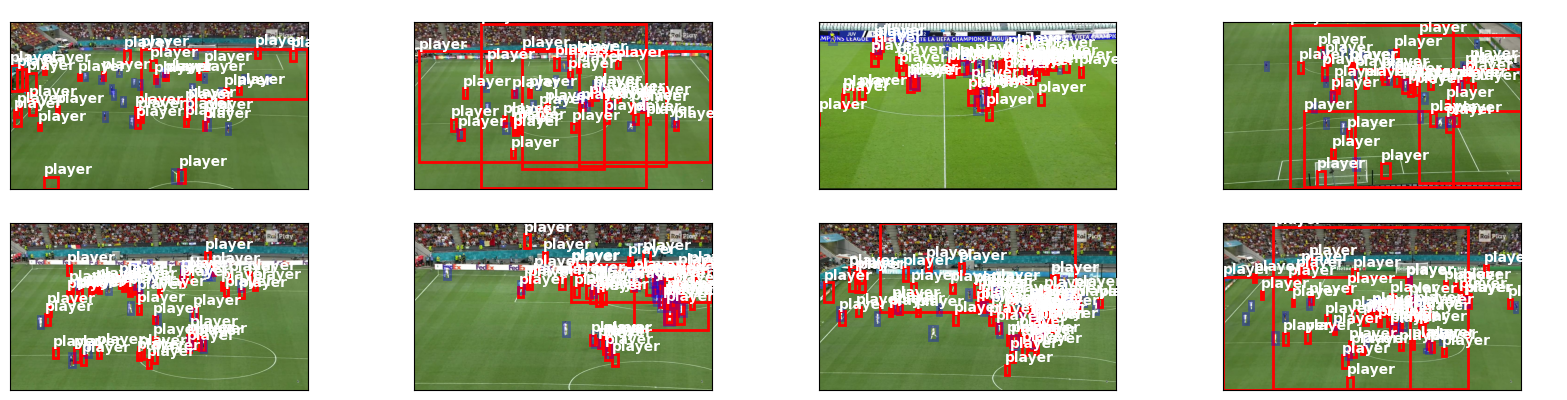

In [56]:
model.eval()
images, targets = next(iter(test_loader))
images = list(image.to(device) for image in images)
preds = model(images)
fig = visualize_imgs(images, preds, targets, rows=4, cols=4, tensors=True)

In [48]:
len(images)

8

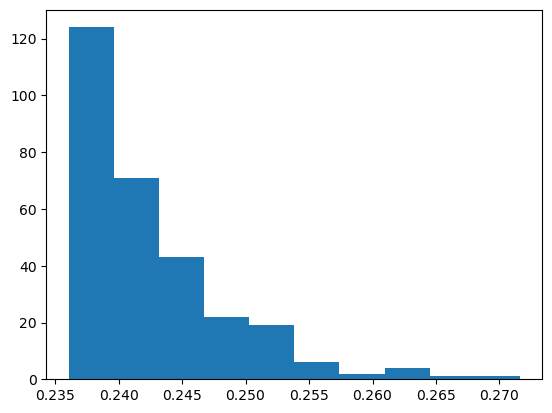

In [59]:
plt.hist([score.cpu().detach() for score in preds[0]['scores']])
plt.show() 

In [43]:
max()

tensor(0.2795, device='cuda:0', grad_fn=<UnbindBackward0>)